In [135]:
#Requirements
#!pip install torchdiffeq
#!pip install POT

In [136]:
from unet2 import UNet

In [137]:
import torch
import os
import argparse
import time
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import ot as ot
import torch.optim as optim
from pathlib import Path
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
from torchdiffeq import odeint_adjoint as odeint

In [138]:
"""From https://github.com/atong01/conditional-flow-matching/blob/main/torchcfm/optimal_transport.py"""
import math
import warnings
from functools import partial
from typing import Optional

import numpy as np
import ot as pot
import torch


class OTPlanSampler:
    """OTPlanSampler implements sampling coordinates according to an OT plan (wrt squared Euclidean
    cost) with different implementations of the plan calculation."""

    def __init__(
        self,
        method: str,
        reg: float = 0.05,
        reg_m: float = 1.0,
        normalize_cost: bool = False,
        warn: bool = True,
    ) -> None:
        """Initialize the OTPlanSampler class.

        Parameters
        ----------
        method: str
            choose which optimal transport solver you would like to use.
            Currently supported are ["exact", "sinkhorn", "unbalanced",
            "partial"] OT solvers.
        reg: float, optional
            regularization parameter to use for Sinkhorn-based iterative solvers.
        reg_m: float, optional
            regularization weight for unbalanced Sinkhorn-knopp solver.
        normalize_cost: bool, optional
            normalizes the cost matrix so that the maximum cost is 1. Helps
            stabilize Sinkhorn-based solvers. Should not be used in the vast
            majority of cases.
        warn: bool, optional
            if True, raises a warning if the algorithm does not converge
        """
        # ot_fn should take (a, b, M) as arguments where a, b are marginals and
        # M is a cost matrix
        if method == "exact":
            self.ot_fn = pot.emd
        elif method == "sinkhorn":
            self.ot_fn = partial(pot.sinkhorn, reg=reg)
        elif method == "unbalanced":
            self.ot_fn = partial(pot.unbalanced.sinkhorn_knopp_unbalanced, reg=reg, reg_m=reg_m)
        elif method == "partial":
            self.ot_fn = partial(pot.partial.entropic_partial_wasserstein, reg=reg)
        else:
            raise ValueError(f"Unknown method: {method}")
        self.reg = reg
        self.reg_m = reg_m
        self.normalize_cost = normalize_cost
        self.warn = warn

    def get_map(self, x0, x1):
        """Compute the OT plan (wrt squared Euclidean cost) between a source and a target
        minibatch.

        Parameters
        ----------
        x0 : Tensor, shape (bs, *dim)
            represents the source minibatch
        x1 : Tensor, shape (bs, *dim)
            represents the source minibatch

        Returns
        -------
        p : numpy array, shape (bs, bs)
            represents the OT plan between minibatches
        """
        a, b = pot.unif(x0.shape[0]), pot.unif(x1.shape[0])
        if x0.dim() > 2:
            x0 = x0.reshape(x0.shape[0], -1)
        if x1.dim() > 2:
            x1 = x1.reshape(x1.shape[0], -1)
        x1 = x1.reshape(x1.shape[0], -1)
        M = torch.cdist(x0, x1) ** 2
        if self.normalize_cost:
            M = M / M.max()  # should not be normalized when using minibatches
        p = self.ot_fn(a, b, M.detach().cpu().numpy())
        if not np.all(np.isfinite(p)):
            print("ERROR: p is not finite")
            print(p)
            print("Cost mean, max", M.mean(), M.max())
            print(x0, x1)
        if np.abs(p.sum()) < 1e-8:
            if self.warn:
                warnings.warn("Numerical errors in OT plan, reverting to uniform plan.")
            p = np.ones_like(p) / p.size
        return p

    def sample_map(self, pi, batch_size, replace=True):
        r"""Draw source and target samples from pi  $(x,z) \sim \pi$

        Parameters
        ----------
        pi : numpy array, shape (bs, bs)
            represents the source minibatch
        batch_size : int
            represents the OT plan between minibatches
        replace : bool
            represents sampling or without replacement from the OT plan

        Returns
        -------
        (i_s, i_j) : tuple of numpy arrays, shape (bs, bs)
            represents the indices of source and target data samples from $\pi$
        """
        p = pi.flatten()
        p = p / p.sum()
        choices = np.random.choice(
            pi.shape[0] * pi.shape[1], p=p, size=batch_size, replace=replace
        )
        return np.divmod(choices, pi.shape[1])

    def sample_plan(self, x0, x1, replace=True):
        r"""Compute the OT plan $\pi$ (wrt squared Euclidean cost) between a source and a target
        minibatch and draw source and target samples from pi $(x,z) \sim \pi$

        Parameters
        ----------
        x0 : Tensor, shape (bs, *dim)
            represents the source minibatch
        x1 : Tensor, shape (bs, *dim)
            represents the source minibatch
        replace : bool
            represents sampling or without replacement from the OT plan

        Returns
        -------
        x0[i] : Tensor, shape (bs, *dim)
            represents the source minibatch drawn from $\pi$
        x1[j] : Tensor, shape (bs, *dim)
            represents the source minibatch drawn from $\pi$
        """
        pi = self.get_map(x0, x1)
        i, j = self.sample_map(pi, x0.shape[0], replace=replace)
        return x0[i], x1[j]

    def sample_plan_with_labels(self, x0, x1, y0=None, y1=None, replace=True):
        r"""Compute the OT plan $\pi$ (wrt squared Euclidean cost) between a source and a target
        minibatch and draw source and target labeled samples from pi $(x,z) \sim \pi$

        Parameters
        ----------
        x0 : Tensor, shape (bs, *dim)
            represents the source minibatch
        x1 : Tensor, shape (bs, *dim)
            represents the target minibatch
        y0 : Tensor, shape (bs)
            represents the source label minibatch
        y1 : Tensor, shape (bs)
            represents the target label minibatch
        replace : bool
            represents sampling or without replacement from the OT plan

        Returns
        -------
        x0[i] : Tensor, shape (bs, *dim)
            represents the source minibatch drawn from $\pi$
        x1[j] : Tensor, shape (bs, *dim)
            represents the target minibatch drawn from $\pi$
        y0[i] : Tensor, shape (bs, *dim)
            represents the source label minibatch drawn from $\pi$
        y1[j] : Tensor, shape (bs, *dim)
            represents the target label minibatch drawn from $\pi$
        """
        pi = self.get_map(x0, x1)
        i, j = self.sample_map(pi, x0.shape[0], replace=replace)
        return (
            x0[i],
            x1[j],
            y0[i] if y0 is not None else None,
            y1[j] if y1 is not None else None,
        )

    def sample_trajectory(self, X):
        """Compute the OT trajectories between different sample populations moving from the source
        to the target distribution.

        Parameters
        ----------
        X : Tensor, (bs, times, *dim)
            different populations of samples moving from the source to the target distribution.

        Returns
        -------
        to_return : Tensor, (bs, times, *dim)
            represents the OT sampled trajectories over time.
        """
        times = X.shape[1]
        pis = []
        for t in range(times - 1):
            pis.append(self.get_map(X[:, t], X[:, t + 1]))

        indices = [np.arange(X.shape[0])]
        for pi in pis:
            j = []
            for i in indices[-1]:
                j.append(np.random.choice(pi.shape[1], p=pi[i] / pi[i].sum()))
            indices.append(np.array(j))

        to_return = []
        for t in range(times):
            to_return.append(X[:, t][indices[t]])
        to_return = np.stack(to_return, axis=1)
        return to_return


def wasserstein(
    x0: torch.Tensor,
    x1: torch.Tensor,
    method: Optional[str] = None,
    reg: float = 0.05,
    power: int = 2,
    **kwargs,
) -> float:
    """Compute the Wasserstein (1 or 2) distance (wrt Euclidean cost) between a source and a target
    distributions.

    Parameters
    ----------
    x0 : Tensor, shape (bs, *dim)
        represents the source minibatch
    x1 : Tensor, shape (bs, *dim)
        represents the source minibatch
    method : str (default : None)
        Use exact Wasserstein or an entropic regularization
    reg : float (default : 0.05)
        Entropic regularization coefficients
    power : int (default : 2)
        power of the Wasserstein distance (1 or 2)
    Returns
    -------
    ret : float
        Wasserstein distance
    """
    assert power == 1 or power == 2
    # ot_fn should take (a, b, M) as arguments where a, b are marginals and
    # M is a cost matrix
    if method == "exact" or method is None:
        ot_fn = pot.emd2
    elif method == "sinkhorn":
        ot_fn = partial(pot.sinkhorn2, reg=reg)
    else:
        raise ValueError(f"Unknown method: {method}")

    a, b = pot.unif(x0.shape[0]), pot.unif(x1.shape[0])
    if x0.dim() > 2:
        x0 = x0.reshape(x0.shape[0], -1)
    if x1.dim() > 2:
        x1 = x1.reshape(x1.shape[0], -1)
    M = torch.cdist(x0, x1)
    if power == 2:
        M = M**2
    ret = ot_fn(a, b, M.detach().cpu().numpy(), numItermax=int(1e7))
    if power == 2:
        ret = math.sqrt(ret)
    return ret

In [139]:
"""Implements Conditional Flow Matcher Losses. From https://github.com/atong01/conditional-flow-matching/blob/main/torchcfm/conditional_flow_matching.py"""

# Author: Alex Tong
#         Kilian Fatras
#         +++
# License: MIT License

import math
import warnings
from typing import Union

import torch


def pad_t_like_x(t, x):
    """Function to reshape the time vector t by the number of dimensions of x.

    Parameters
    ----------
    x : Tensor, shape (bs, *dim)
        represents the source minibatch
    t : FloatTensor, shape (bs)

    Returns
    -------
    t : Tensor, shape (bs, number of x dimensions)

    Example
    -------
    x: Tensor (bs, C, W, H)
    t: Vector (bs)
    pad_t_like_x(t, x): Tensor (bs, 1, 1, 1)
    """
    if isinstance(t, (float, int)):
        return t
    return t.reshape(-1, *([1] * (x.dim() - 1)))


class ConditionalFlowMatcher:
    """Base class for conditional flow matching methods. This class implements the independent
    conditional flow matching methods from [1] and serves as a parent class for all other flow
    matching methods.

    It implements:
    - Drawing data from gaussian probability path N(t * x1 + (1 - t) * x0, sigma) function
    - conditional flow matching ut(x1|x0) = x1 - x0
    - score function $\nabla log p_t(x|x0, x1)$
    """

    def __init__(self, sigma: Union[float, int] = 0.0):
        r"""Initialize the ConditionalFlowMatcher class. It requires the hyper-parameter $\sigma$.

        Parameters
        ----------
        sigma : Union[float, int]
        """
        self.sigma = sigma

    def compute_mu_t(self, x0, x1, t):
        """
        Compute the mean of the probability path N(t * x1 + (1 - t) * x0, sigma), see (Eq.14) [1].

        Parameters
        ----------
        x0 : Tensor, shape (bs, *dim)
            represents the source minibatch
        x1 : Tensor, shape (bs, *dim)
            represents the target minibatch
        t : FloatTensor, shape (bs)

        Returns
        -------
        mean mu_t: t * x1 + (1 - t) * x0

        References
        ----------
        [1] Improving and Generalizing Flow-Based Generative Models with minibatch optimal transport, Preprint, Tong et al.
        """
        t = pad_t_like_x(t, x0)
        return t * x1 + (1 - t) * x0

    def compute_sigma_t(self, t):
        """
        Compute the standard deviation of the probability path N(t * x1 + (1 - t) * x0, sigma), see (Eq.14) [1].

        Parameters
        ----------
        t : FloatTensor, shape (bs)

        Returns
        -------
        standard deviation sigma

        References
        ----------
        [1] Improving and Generalizing Flow-Based Generative Models with minibatch optimal transport, Preprint, Tong et al.
        """
        del t
        return self.sigma

    def sample_xt(self, x0, x1, t, epsilon):
        """
        Draw a sample from the probability path N(t * x1 + (1 - t) * x0, sigma), see (Eq.14) [1].

        Parameters
        ----------
        x0 : Tensor, shape (bs, *dim)
            represents the source minibatch
        x1 : Tensor, shape (bs, *dim)
            represents the target minibatch
        t : FloatTensor, shape (bs)
        epsilon : Tensor, shape (bs, *dim)
            noise sample from N(0, 1)

        Returns
        -------
        xt : Tensor, shape (bs, *dim)

        References
        ----------
        [1] Improving and Generalizing Flow-Based Generative Models with minibatch optimal transport, Preprint, Tong et al.
        """
        mu_t = self.compute_mu_t(x0, x1, t)
        sigma_t = self.compute_sigma_t(t)
        sigma_t = pad_t_like_x(sigma_t, x0)
        return mu_t + sigma_t * epsilon

    def compute_conditional_flow(self, x0, x1, t, xt):
        """
        Compute the conditional vector field ut(x1|x0) = x1 - x0, see Eq.(15) [1].

        Parameters
        ----------
        x0 : Tensor, shape (bs, *dim)
            represents the source minibatch
        x1 : Tensor, shape (bs, *dim)
            represents the target minibatch
        t : FloatTensor, shape (bs)
        xt : Tensor, shape (bs, *dim)
            represents the samples drawn from probability path pt

        Returns
        -------
        ut : conditional vector field ut(x1|x0) = x1 - x0

        References
        ----------
        [1] Improving and Generalizing Flow-Based Generative Models with minibatch optimal transport, Preprint, Tong et al.
        """
        del t, xt
        return x1 - x0

    def sample_noise_like(self, x):
        return torch.randn_like(x)

    def sample_location_and_conditional_flow(self, x0, x1, t=None, return_noise=False):
        """
        Compute the sample xt (drawn from N(t * x1 + (1 - t) * x0, sigma))
        and the conditional vector field ut(x1|x0) = x1 - x0, see Eq.(15) [1].

        Parameters
        ----------
        x0 : Tensor, shape (bs, *dim)
            represents the source minibatch
        x1 : Tensor, shape (bs, *dim)
            represents the target minibatch
        (optionally) t : Tensor, shape (bs)
            represents the time levels
            if None, drawn from uniform [0,1]
        return_noise : bool
            return the noise sample epsilon


        Returns
        -------
        t : FloatTensor, shape (bs)
        xt : Tensor, shape (bs, *dim)
            represents the samples drawn from probability path pt
        ut : conditional vector field ut(x1|x0) = x1 - x0
        (optionally) eps: Tensor, shape (bs, *dim) such that xt = mu_t + sigma_t * epsilon

        References
        ----------
        [1] Improving and Generalizing Flow-Based Generative Models with minibatch optimal transport, Preprint, Tong et al.
        """
        if t is None:
            t = torch.rand(x0.shape[0]).type_as(x0)
        assert len(t) == x0.shape[0], "t has to have batch size dimension"

        eps = self.sample_noise_like(x0)
        xt = self.sample_xt(x0, x1, t, eps)
        ut = self.compute_conditional_flow(x0, x1, t, xt)
        if return_noise:
            return t, xt, ut, eps
        else:
            return t, xt, ut

    def compute_lambda(self, t):
        """Compute the lambda function, see Eq.(23) [3].

        Parameters
        ----------
        t : FloatTensor, shape (bs)

        Returns
        -------
        lambda : score weighting function

        References
        ----------
        [4] Simulation-free Schrodinger bridges via score and flow matching, Preprint, Tong et al.
        """
        sigma_t = self.compute_sigma_t(t)
        return 2 * sigma_t / (self.sigma**2 + 1e-8)


class ExactOptimalTransportConditionalFlowMatcher(ConditionalFlowMatcher):
    """Child class for optimal transport conditional flow matching method. This class implements
    the OT-CFM methods from [1] and inherits the ConditionalFlowMatcher parent class.

    It overrides the sample_location_and_conditional_flow.
    """

    def __init__(self, sigma: Union[float, int] = 0.0):
        r"""Initialize the ConditionalFlowMatcher class. It requires the hyper-parameter $\sigma$.

        Parameters
        ----------
        sigma : Union[float, int]
        ot_sampler: exact OT method to draw couplings (x0, x1) (see Eq.(17) [1]).
        """
        super().__init__(sigma)
        self.ot_sampler = OTPlanSampler(method="exact")

    def sample_location_and_conditional_flow(self, x0, x1, t=None, return_noise=False):
        r"""
        Compute the sample xt (drawn from N(t * x1 + (1 - t) * x0, sigma))
        and the conditional vector field ut(x1|x0) = x1 - x0, see Eq.(15) [1]
        with respect to the minibatch OT plan $\Pi$.

        Parameters
        ----------
        x0 : Tensor, shape (bs, *dim)
            represents the source minibatch
        x1 : Tensor, shape (bs, *dim)
            represents the target minibatch
        (optionally) t : Tensor, shape (bs)
            represents the time levels
            if None, drawn from uniform [0,1]
        return_noise : bool
            return the noise sample epsilon

        Returns
        -------
        t : FloatTensor, shape (bs)
        xt : Tensor, shape (bs, *dim)
            represents the samples drawn from probability path pt
        ut : conditional vector field ut(x1|x0) = x1 - x0
        (optionally) epsilon : Tensor, shape (bs, *dim) such that xt = mu_t + sigma_t * epsilon

        References
        ----------
        [1] Improving and Generalizing Flow-Based Generative Models with minibatch optimal transport, Preprint, Tong et al.
        """
        x0, x1 = self.ot_sampler.sample_plan(x0, x1)
        return super().sample_location_and_conditional_flow(x0, x1, t, return_noise)


In [140]:
"""Stolen from https://github.com/cfinlay/ffjord-rnode/blob/master/lib/layers/odefunc.py"""

def divergence_approx(f, y, e=None):

    samples = []
    sqnorms = []
    for  e_ in e:
        e_dzdx = torch.autograd.grad(f, y, e_, create_graph=True)[0]
        n = e_dzdx.view(y.size(0),-1).pow(2).mean(dim=1, keepdim=True)
        sqnorms.append(n)
        e_dzdx_e = e_dzdx * e_
        samples.append(e_dzdx_e.view(y.shape[0], -1).sum(dim=1, keepdim=True))

    S = torch.cat(samples, dim=1)
    approx_tr_dzdx = S.mean(dim=1)

    N = torch.cat(sqnorms, dim=1).mean(dim=1)


    return approx_tr_dzdx, N

In [141]:
"""Augmented ODE to train RNODE"""
class regularized_Augmented_ODE2(nn.Module):
    def __init__(self, ode_func: nn.Module):
        super().__init__()
        self.odefunc = ode_func

    def forward(self, t, states):

        z = states[0]         
        with torch.set_grad_enabled(True):
            z.requires_grad_(True)                                          #dynamics 
            dz_dt = self.odefunc(t, z)
            epsilon = torch.randn_like(z)
            dlog_det_dt, dn_dt = divergence_approx(dz_dt, z, e=epsilon.unsqueeze(0))
            dE_dt = (torch.linalg.matrix_norm(dz_dt)**2)          #kinetic Energy

            """            
            print("dz_dt: ", dz_dt.shape)
            print("dlog_det_dt: ", dlog_det_dt.shape)
            print("dE_dt: ", dE_dt.shape)
            print("dn_dt: ", dn_dt.shape)
            """
            return (dz_dt, dlog_det_dt, dE_dt, dn_dt)

In [143]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [144]:
"""Dynamics, i.e., right hand side of the ODE"""
class NODE(nn.Module):
    def __init__(self, convnet):
        super().__init__()
        self.net = convnet

    def forward(self, t, x):
        return self.net(t, x)
    
    """plots the ode solutions from its initial value x at time 0 to the final solution at time 1 (t decides number of steps)"""
    def plot_trajectories(self, trajectories=None, t=None, x=None):
        fig, ax = plt.subplots()
        with torch.no_grad():
            if trajectories == None:
                trajectories = odeint(self, x, t, method="rk4")

            ax.plot(trajectories[:,:,0], trajectories[:,:,1], color="silver", alpha=.7, zorder=0, label="flow")            
            ax.scatter(trajectories[0,:,0],trajectories[0,:,1], c="royalblue", s=1, label="prior sample", zorder=1)
            ax.scatter(trajectories[-1,:,0], trajectories[-1,:,1], c="darkorange", s=1, label="gen sample", zorder=1)

            handles, labels = plt.gca().get_legend_handles_labels()
            by_label = dict(zip(labels, handles))
            plt.legend(by_label.values(), by_label.keys())
        
        return fig, ax
    
    """log probability of the model with a normal gaussian as the initial distribution"""
    def log_probability(self, t, x):
        initial_distr = torch.distributions.MultivariateNormal(torch.zeros(28), torch.eye(28))

        l0 = torch.zeros((x.size(0),1), requires_grad=False)
        initial_values = (x, l0)

        augmented_dynamics = trace_Augmented_ODE(self)

        z_t, log_det = odeint(augmented_dynamics, initial_values, t, method="rk4")

        logp_x = initial_distr.log_prob(z_t[-1]) + log_det[-1]

        return -logp_x.mean()
    
    """computes the average length of the trajectories from the initial values x to the values at the final timestep"""
    def length_trajectories(self, trajectories=None, t=None, x=None):
        with torch.no_grad():
            if trajectories == None:
                trajectories = odeint(self, x, t, method="rk4")
            distances = torch.linalg.norm(trajectories[1:] - trajectories[:-1], dim=-1)
            length = distances.sum(dim=0)

            return length.mean()
        
    "computes the Wasserstein2 distance between samples generated from the initial values x and samples y from the true distribution"
    def wasserstein2_distance(self, y, trajectories=None, t=None, x=None):
        with torch.no_grad():
            if trajectories == None:
                trajectories = odeint(self, x, t, method="rk4")
            z = trajectories[-1]
            a, b = ot.unif(z.size(0)), ot.unif(y.size(0))
            cost = torch.cdist(z, y) ** 2
            distance = ot.emd2(a, b, cost.numpy())

            return distance**.5

    
"""Augmented ODE for CNF without any regularization and choice of samples for the Hutchinson trace estimator and no gradient"""
class trace_Augmented_ODE(nn.Module):
    def __init__(self, ode_func: nn.Module):
        super().__init__()
        self.odefunc = ode_func

    def forward(self, t, states):
        with torch.no_grad():
            z = states[0]
            dz_dt, dlogp_z_dt =  self.hutchinson_trace_estimator(t, z)
            return (dz_dt, dlogp_z_dt)
        
    def hutchinson_trace_estimator(self, t, z, samples=20):
        trace = 0
        
        for _ in range(samples):
            epsilon = torch.randn_like(z)
            output_f, vjp_f = torch.autograd.functional.vjp(self.odefunc, (t,z), v=epsilon, create_graph=False)
            trace +=  (vjp_f[1]*epsilon).sum(1).unsqueeze(1)    

        return output_f, trace/samples
    
"""Augmented ODE to train NODE"""
class Augmented_ODE(nn.Module):
    def __init__(self, ode_func: nn.Module):
        super().__init__()
        self.odefunc = ode_func

    def forward(self, t, states):
        with torch.set_grad_enabled(True):
            z = states[0]                                                               #dynamics 
            dz_dt, vjp_f, epsilon = self.vjp(self.odefunc, t, z)
            dlog_det_dt =  (vjp_f*epsilon).sum(-1).sum(-1)                     #log-det of the Jacobian   
            
            return (dz_dt, dlog_det_dt)

    def vjp(self, f, t, z):
        """computes vector Jacobian product and returns (output of the function, vjp, epsilon)"""
        epsilon = torch.randn_like(z)
        output_f, vjp_f = torch.autograd.functional.vjp(f, (t,z), v=epsilon, create_graph=True)
        return output_f, vjp_f[1], epsilon



"""Augmented ODE to train RNODE"""
class regularized_Augmented_ODE(nn.Module):
    def __init__(self, ode_func: nn.Module):
        super().__init__()
        self.odefunc = ode_func

    def forward(self, t, states):
        with torch.set_grad_enabled(True):
            z = states[0]                                                               #dynamics 
            dz_dt, vjp_f, epsilon = self.vjp(self.odefunc, t, z)
            dlog_det_dt =  (vjp_f*epsilon).sum(-1).sum(-1)                     #log-det of the Jacobian   
            dE_dt = (torch.linalg.matrix_norm(dz_dt)**2)          #kinetic Energy
            dn_dt = (torch.linalg.matrix_norm(vjp_f)**2)          #Frobenius norm of the Jacobian

            """            
            print("dz_dt: ", dz_dt.shape)
            print("dlog_det_dt: ", dlog_det_dt.shape)
            print("dE_dt: ", dE_dt.shape)
            print("dn_dt: ", dn_dt.shape)
            """
            return (dz_dt, dlog_det_dt, dE_dt, dn_dt)

    def vjp(self, f, t, z):
        """computes vector Jacobian product and returns (output of the function, vjp, epsilon)"""
        epsilon = torch.randn_like(z)
        output_f, vjp_f = torch.autograd.functional.vjp(f, (t,z), v=epsilon, create_graph=True)
        return output_f, vjp_f[1], epsilon

    
    
"""computes the loss of RNODE, given the dynamics 'model' and samples 'x'"""
def rnode_loss(model: torch.nn.Module, x, lambda_k: float, lambda_j: float):
    initial_distr = torch.distributions.MultivariateNormal(torch.zeros(28), torch.eye(28))
    t = torch.linspace(0, 1, 5).type(torch.float32)
    l0 = torch.zeros((x.size(0),1), requires_grad=True)
    kin_E0 = torch.zeros((x.size(0),1), requires_grad=True)
    n0 = torch.zeros((x.size(0),1), requires_grad=True)
    initial_values = (x, l0, kin_E0, n0)

    augmented_dynamics = regularized_Augmented_ODE(model)

    z_t, log_det, E_t, n_t = odeint(augmented_dynamics, initial_values, t,
                                    method="rk4")

    z1, l1, kin_E1, n1 = z_t[-1], log_det[-1], E_t[-1], n_t[-1]

    logp_x = initial_distr.log_prob(z1) + l1 - lambda_k * kin_E1 - lambda_j * n1
    loss = -logp_x.mean()

    return loss


In [145]:
def rnode_training(epochs, seed, learning_rate, lambda_k, lambda_j):

    torch.manual_seed(seed)
    np.random.seed(seed)
    
    model = UNet(
            input_channels=1,
            input_height=28,
            ch=32,
            ch_mult=(1, 2,4),
            num_res_blocks=2,
            attn_resolutions=(16,),
            resamp_with_conv=True,
            dropout=0,
            )

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    model.train()
    epoch_loss = 0
    initial_distr = torch.distributions.MultivariateNormal(torch.zeros(28), torch.eye(28))
    start = time.time()
    Path("mnist/rnode/models").mkdir(parents=True, exist_ok=True)

    for epoch in range(epochs):
        running_loss = 0.0
        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f'Epoch {epoch + 1}/{epochs}')
        num = 0
        for i, (samples, labels) in progress_bar:
            optimizer.zero_grad()
            #samples.requires_grad = True

            x0 = samples
            
            t = torch.linspace(1, 0, 5).type(torch.float32)
            l0 = torch.zeros((x0.size(0),1), requires_grad=True)
            kin_E0 = torch.zeros((x0.size(0),1), requires_grad=True)
            n0 = torch.zeros((x0.size(0),1), requires_grad=True)
            initial_values = (x0, l0, kin_E0, n0)

            augmented_dynamics = regularized_Augmented_ODE(model)

            z_t, log_det, E_t, n_t = odeint(augmented_dynamics, initial_values, t, method="dopri5", rtol=1e-5, atol=1e-5)
            print("yay")
            z1, l1, kin_E1, n1 = z_t[-1], log_det[-1], E_t[-1], n_t[-1]

            logp_x = initial_distr.log_prob(z1) + l1 - lambda_k * kin_E1 - lambda_j * n1
            loss = -logp_x.mean()

            loss.backward()
            optimizer.step()

            epoch_loss += loss
            num += 1
        
        torch.save(model.state_dict(), os.path.join("mnist/rnode/models", f"{epoch}_model.pt"))
        print(f"\nloss: {loss/num}")
        

    print("finished training")


In [146]:
"""Training loop for OT-CFM"""
def cfm_training(epochs, seed, learning_rate, sigma):

    torch.manual_seed(seed)
    np.random.seed(seed)

    model = UNet(
            input_channels=1,
            input_height=28,
            ch=32,
            ch_mult=(1, 2,4),
            num_res_blocks=2,
            attn_resolutions=(16,),
            resamp_with_conv=True,
            dropout=0,
            )
    optimizer = optim.Adam(model.parameters(), lr = learning_rate)
    FM = ExactOptimalTransportConditionalFlowMatcher(sigma=sigma)

    model.train()

    start = time.time()
    Path("mnist/cfm/models").mkdir(parents=True, exist_ok=True)

    for epoch in range(epochs):
        epoch_loss = 0.0
        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f'Epoch {epoch + 1}/{epochs}')
        num = 0
        for i, (samples, labels) in progress_bar:
            optimizer.zero_grad()

            x0 = torch.randn_like(samples)
            t, xt, ut = FM.sample_location_and_conditional_flow(x0, samples)
            vt = model(t, xt)
            loss = torch.mean((vt - ut) ** 2)
            loss.backward()
            #print(loss)
            optimizer.step()

            epoch_loss += loss
            num += 1
        
        torch.save(model.state_dict(), os.path.join("mnist/cfm/models", f"{epoch}_model.pt"))
        print(f"\nloss: {epoch_loss/num}")
        

    print("finished training")

In [147]:
def save_hyperparameters_and_metrics(file_path: str, hyperparameters: dict, metrics: dict):
    with open(file_path, "w") as file:
        file.write("Hyperparameters:\n")
        for param, value in hyperparameters.items():
            file.write(f"{param}: {value}\n")

        file.write("\nMetrics per  batches:\n")
        file.write("batches, loss, negative_log_likelihood, flow_length, wasserstein2_distance, elapsed_time\n")
        for  batches in range(len(metrics["batches"])):
            file.write(f"{metrics['batches'][batches]}, {metrics['loss'][batches]}, {metrics['log_probability'][batches]}, {metrics['flow_length'][batches]}, {metrics['wasserstein2_distance'][batches]}, {metrics['elapsed_time'][batches]}\n")
        
        file.write(f"total time: {sum(metrics['elapsed_time'])}")

In [148]:

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 128
n_epochs = 10
learning_rate=1e-3
seed = 44
lambda_k = .1
lambda_j = .1
sigma = 0.0

In [149]:
#cfm_training(n_epochs, seed, learning_rate, sigma)

In [150]:
rnode_training(n_epochs, seed, learning_rate, lambda_k, lambda_j)

Epoch 1/10:   0%|          | 0/469 [00:00<?, ?it/s]

yay


Epoch 1/10:   0%|          | 0/469 [05:22<?, ?it/s]


KeyboardInterrupt: 

torch.Size([1, 1, 28, 28])


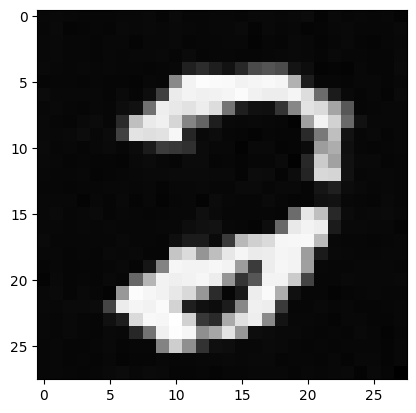

In [153]:
model = model = UNet(
            input_channels=1,
            input_height=28,
            ch=32,
            ch_mult=(1, 2,4),
            num_res_blocks=2,
            attn_resolutions=(16,),
            resamp_with_conv=True,
            dropout=0,
            )
model.load_state_dict(torch.load("mnist/cfm/models/0_model.pt"))
model.eval()

samples = next(iter(test_loader))[0][0].unsqueeze(0)
a = torch.randn_like(samples)

print(samples.shape)

with torch.no_grad():
    gen = odeint(model, a, torch.linspace(0, 1, 20).type(torch.float32), method="dopri5")

b = gen[-1,0,0]
#print(a[0,0]==b)
plt.imshow(b, cmap="gray")
